In [1]:
## 
import torch
from torch import nn
import pandas as pd
import os
import numpy as np
import COSMO_TL as ctl
from dask.distributed import Client, LocalCluster, progress
import dask
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interpn
from scipy.interpolate import LinearNDInterpolator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import  mean_squared_error, r2_score, mean_absolute_error
from scipy.optimize import curve_fit, minimize, differential_evolution
# get particle swarm optimizer
from pyswarm import pso
import time
import os
import pickle
import datetime
import kmodels as kmk
import shutil
import dask.dataframe as dd


def get_X_solute(df):
    X = df[['volume_solute', 'area_solute', 'NC_K', 'SIGMA_K','TAU']]
    sig_cols = [col for col in df.columns if 'sigma_solute' in col]
    sigs = df[sig_cols].to_numpy()
    X = X.to_numpy().reshape(len(df), -1)
    X = np.column_stack((X, sigs))
    return X

def get_X_solvent(df):
    X = df[['volume_solvent', 'area_solvent','NC_K','SIGMA_K','TAU']]
    sig_cols = [col for col in df.columns if 'sigma_solvent' in col]
    sigs = df[sig_cols].to_numpy()
    X = X.to_numpy().reshape(len(df), -1)
    X = np.column_stack((X, sigs))
    return X

def get_X(df):
    X_solute = get_X_solute(df)
    X_solvent = get_X_solvent(df)
    # solvent prop cols = eps,n,alpha,beta,gamma,phi**2,psi**2,beta**2
    solvent_props_names = ['eps', 'n', 'alpha', 'beta', 'gamma', 'phi**2', 'psi**2', 'beta**2']
    solvent_props = df[solvent_props_names].to_numpy()
    X = np.column_stack((X_solute, X_solvent, solvent_props))
    return X
# given a dataframe return a dataframe with the mean value for all columns with error in the name
# grouped by SoluteName
def get_mean_df(df):
    df2 = df.copy()
    original_columns = list(df2.columns)
    print(original_columns)
    cols = [col for col in df2.columns if 'error' in col]
    original_columns = [col for col in original_columns if col not in cols]
    df3 = df2.groupby(['SoluteName', 'NC_K','SIGMA_K','TAU'])[cols].mean()
    df3 = df3.reset_index()
    # return a dataframe with the unique values in SoluteName and the mean values for all columns with error in the name
    # get all the other colums  from the original dataframe
    df4 = df2[original_columns]
    df4 = df4.reset_index(drop=True)
    df5 = pd.merge(df4, df3, on=['SoluteName', 'NC_K','SIGMA_K','TAU'])
    df5 = df5.drop_duplicates()
    return df5

def get_n_params(model):
    n_params = 0
    for param in model.parameters():
        n_params += param.numel()
    return n_params

csv_path = '../data/vaspsol_data_3_2_2023.csv'

df = pd.read_csv(csv_path)
#df = dd.read_parquet(csv_path)
#df = df.compute()
print(df)
df['error'] = df['error'].abs()
df = df[df['error'] < 10]
df = df[df['Solvent'] == 'water']
df = df[df['Charge'] == 0]
NC_K_default = 0.0025
SIGMA_K_default = 0.6
TAU_default = 0.000525
# default_df = df[(df['NC_K'] == NC_K_default) & (df['SIGMA_K'] == SIGMA_K_default) & (df['TAU'] == TAU_default)]
# print(default_df)



# df_to_append = default_df[['SoluteName','error']]
# # rename error to default_error
# df_to_append = df_to_append.rename(columns={'error': 'default_error'})
# df_to_append


# # match up the default error back to the original dataframe
# df = pd.merge(df, df_to_append, on=['SoluteName'])
# # this expanded the number of rows in the dataframe. This is not what we want
#df = df.drop_duplicates('Unnamed: 0')

groups = df[df['Solvent']=='water'].groupby(['NC_K', 'SIGMA_K', 'TAU'])
# print(df)

df_test = pd.read_csv(csv_path)
#df_test = dd.read_parquet(csv_path)
#df_test = df_test.compute()
# we want the NC_K, SIGMA_K and TAU combinations that are not in 
# the training set
df_test = df_test[~df_test[['NC_K', 'SIGMA_K', 'TAU']].isin(df[['NC_K', 'SIGMA_K', 'TAU']]).all(axis=1)]
default_df = df_test[(df_test['NC_K'] == NC_K_default) & (df_test['SIGMA_K'] == SIGMA_K_default) & (df_test['TAU'] == TAU_default)]
print(default_df)

# get the number of unique groups
# using the groups split of the dataframe so that unique combos of NC_K, SIGMA_K, and TAU are in each group
split = 0.99
## get the unique groups
#groups = df.groupby(['NC_K', 'SIGMA_K', 'TAU'])
# get the indicies of the groups
indicies = [np.array(i) for i in groups.indices.values()]
# get the number of groups
num_groups = len(indicies)
print('Number of groups: ', num_groups)

# get the number of groups to use for training
num_train_groups = int(num_groups*split)
print('Number of groups to use for training: ', num_train_groups)
print('Number of groups to use for testing: ', num_groups - num_train_groups)
# get the indicies of the groups to use for training
print(len(indicies))

idx_temp = np.arange(len(indicies))
train_indicies = [indicies[i] for i in np.random.choice(idx_temp, size=num_train_groups, replace=False)]
train_indicies = np.concatenate(train_indicies)
# get the indicies of the groups to use for testing
test_indicies = np.array([i for i in np.concatenate(indicies) if i not in train_indicies])
train_df = df.iloc[train_indicies]
test_df = df.iloc[test_indicies]

X_train = get_X_solute(train_df)
X_test = get_X_solute(test_df)
y_train = train_df['error'].to_numpy()
y_test = test_df['error'].to_numpy()
X_test = get_X_solute(test_df)

# print out the shape of the training data and the training labels. Nice retro looking print statment
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')
n_observations_train = X_train.shape[0]
n_features_train = X_train.shape[1]
n_observations_test = X_test.shape[0]
n_features_test = X_test.shape[1]

print('TRAINING SET DETAILS')
print(f'Number of observations: {n_observations_train}')
print(f'Number of features: {n_features_train}')

print('TESTING SET DETAILS')
print(f'Number of observations: {n_observations_test}')
print(f'Number of features: {n_features_test}')



scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape)
# send the training data to gpu
X_train = torch.from_numpy(X_train).float().reshape(-1, n_features_train)
y_train = torch.from_numpy(y_train).float().reshape(-1, 1)
X_test = torch.from_numpy(X_test).float().reshape(-1, n_features_train)

# lets make a new auto encoder that uses n_dim to make a n_layers with n_dim in the middle
# lets make a function that given a desired depth will report a appropriate topology 
# example 3 layers 11 features would be 11, 7, 3

def get_topology(n_features, depth, out_features=3):
    topology = []
    for i in range(depth):
        if i == 0:
            topology.append(n_features)
        else:
            topology.append(int(topology[i-1] / 2))
            if topology[i] < out_features:
                topology[i] = out_features
    topology.append(out_features)
    return topology

# test
get_topology(11, 3,)
4284/204
class autoNN(nn.Module):
    def __init__(self, n_inputs=11, n_dimensions=3, n_layers=3):
        super(autoNN, self).__init__()
        self.n_inputs = n_inputs
        self.n_dimensions = n_dimensions
        self.n_layers = n_layers
        self.topology = get_topology(n_inputs, n_layers, n_dimensions)
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        print(self.topology)
        for i in range(n_layers):
            if i == 0:
                self.encoder.append(nn.Linear(n_inputs, self.topology[i+1]))
            else:
                self.encoder.append(nn.Linear(self.topology[i], self.topology[i+1]))
            self.encoder.append(nn.ReLU())
        self.encoder = self.encoder[:-1]
        # invert the encoder using the encoder object
        for i in self.encoder[::-1]:
            if isinstance(i, nn.Linear):
                self.decoder.append(nn.Linear(i.out_features, i.in_features))
                self.decoder.append(nn.ReLU())
        self.decoder = self.decoder[:-1]
                   
    
    def forward(self, x):
        # encode the input
        for layer in self.encoder:
            x = layer(x)
        # decode the input
        for layer in self.decoder:
            x = layer(x)
        return x
    
    def encode(self, x):
        for layer in self.encoder:
            x = layer(x)
        return x
    def decode(self, x):
        for layer in self.decoder:
            x = layer(x)
        return x
# append y data to the end of the x data
#X_to_code = torch.cat((X_train, y_train), dim=1)
X_to_code = X_train
auto = autoNN(n_inputs=n_features_train, n_dimensions=5, n_layers=2)
print(get_n_params(auto))
losses = kmk.run_Pytorch(auto, X_to_code, X_to_code, n_epochs=1, batch_size=1, learning_rate=1e-3)

c:\Users\efons\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


      Unnamed: 0       Solvent FileHandle    NC_K   SIGMA_K       TAU  \
0              0         water    0157flu  0.0010  0.200000  0.000670   
1              1         water    0157flu  0.0020  0.866667  0.000010   
2              2         water    0157flu  0.0010  1.200000  0.001000   
3              3         water    0157flu  0.0010  0.200000  0.001000   
4              4         water    0157flu  0.0030  0.533333  0.000340   
...          ...           ...        ...     ...       ...       ...   
6534        6534       mcresol    0036tol  0.0025  0.600000  0.000525   
6535        6535   bromoethane    0036tol  0.0025  0.600000  0.000525   
6536        6536  butylbenzene    0078pen  0.0025  0.600000  0.000525   
6537        6537    secbutanol    0069met  0.0025  0.600000  0.000525   
6538        6538    secbutanol    0509sec  0.0025  0.600000  0.000525   

      Solvation_Energy  Total_Energy   No.     SoluteName  ...  \
0             0.073867    -76.193434  2240  fluorobenzene

In [22]:

n_params = get_n_params(auto)
n_params

3533

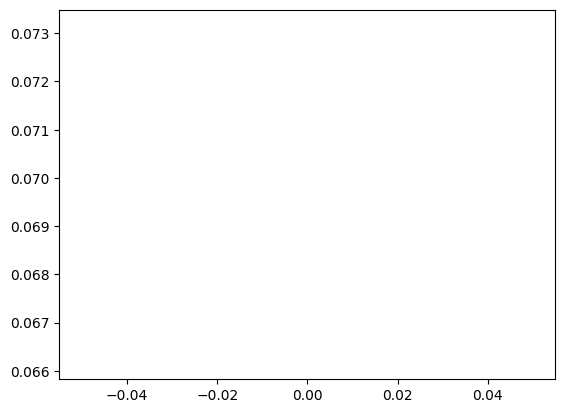

In [23]:
plt.plot(losses)

In [4]:
# plot a sample of the first observation
test = X_to_code[0].reshape(1, -1)
test_hat = auto(test.cuda())

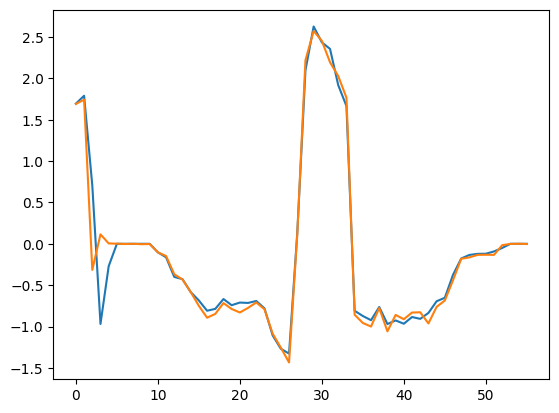

In [5]:
plt.plot(test.cpu().detach().numpy().reshape(-1))
plt.plot(test_hat.cpu().detach().numpy().reshape(-1))

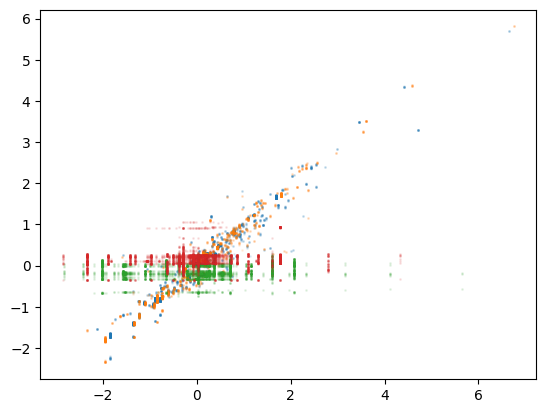

In [6]:
# make a parity plot of only the first 5 columns. plot the prediciton of all the values in X_to_code
# and the actual values of X_to_code
X_to_code_hat = auto(X_to_code.cuda())
X_to_code_hat = X_to_code_hat.cpu().detach().numpy()

a = 0.1
plt.scatter(X_to_code[:, 0], X_to_code_hat[:, 0], alpha=a, s=1)
plt.scatter(X_to_code[:, 1], X_to_code_hat[:, 1], alpha=a, s=1)
plt.scatter(X_to_code[:, 2], X_to_code_hat[:, 2], alpha=a, s=1)
plt.scatter(X_to_code[:, 3], X_to_code_hat[:, 3], alpha=a, s=1)

In [7]:
# lets use the encoder to make a new dataset
import seaborn as sns
X_encoded = auto.encode(X_to_code.cuda())
print(X_encoded.shape)

torch.Size([5620, 5])


In [8]:
model_prime = kmk.NN(n_inputs=X_encoded.shape[1], n_outputs=1, layers=3, layer_size=10)
model_prime, get_n_params(model_prime)

(NN(
   (fc1): Linear(in_features=5, out_features=10, bias=True)
   (fcs): ModuleList(
     (0): Linear(in_features=10, out_features=10, bias=True)
     (1): Linear(in_features=10, out_features=10, bias=True)
     (2): Linear(in_features=10, out_features=10, bias=True)
   )
   (fout): Linear(in_features=10, out_features=1, bias=True)
 ),
 401)

In [ ]:
# lets makes some random search models 
random_params = kmk.get_random_params()
random_params

{'layers': 6,
 'layer_size': 31,
 'learning_rate': 0.0015572898654149603,
 'weight_decay': 0.07480087351554839,
 'batch_size': 1984}

In [24]:
# make a function that takes in a params dict and constrcuts a kmk.NN model
def make_model(params, n_inputs=56, n_outputs=1):
    model = kmk.NN(n_inputs=n_inputs, n_outputs=n_outputs, layers=params['layers'], layer_size=params['layer_size'])
    return model
# test
make_model(random_params)

# make a function that given n_iter will make n_iter models and return a list of models
def make_models(n_iter):
    models = []
    for i in range(n_iter):
        params = kmk.get_random_params()
        model = make_model(params)
        models.append(model)
    return models

# test
models = make_models(10)

# lets make a class that will store the model, the parmams, the losses and the training stats. It will contian the following methods:  
# 1. train: trains the model and stores the losses and training stats
# 2. predict: returns the predictions of the model
# 3. score: returns the score of the model
# 4. get_params: returns the params of the model
# 5. get_losses: returns the losses of the model
# 6. get_training_stats: returns the training stats of the model
# 7. get_model: returns the model
class Model:
    def __init__(self, model, params):
        self.model = model
        self.params = params
        self.losses = []
        self.training_stats = []
        self.predictions = []
    def train(self, X, y, n_epochs=1000):
        self.losses = kmk.run_Pytorch(self.model, X, y, n_epochs=n_epochs, batch_size=self.params['batch_size'], learning_rate=self.params['learning_rate'])
        # get the mse, r2, rmse, mae as the training stats
        pred = self.predict(X).detach().cpu().numpy()
        r2 = kmk.r2_score(y, pred)
        mse = kmk.mean_squared_error(y, pred)
        rmse = kmk.mean_squared_error(y, pred)**0.5
        mae = kmk.mean_absolute_error(y, pred)
        self.training_stats = pd.DataFrame({'r2': r2, 'mse': mse, 'rmse': rmse, 'mae': mae}, index=[0])
    def predict(self, X):
        self.predictions = self.model(X)
        return self.predictions
    def get_params(self):
        return self.params
    def get_losses(self):
        return self.losses
    def get_model(self):
        return self.model
    
# test with random params
params = kmk.get_random_params()
model = make_model(params)
model_prime = Model(model, params)
model_prime.train(X_encoded.detach(), y_train, n_epochs=1)

EPOCH :  0 , dt:  0.25869035720825195 seconds, losses : 5.084838390350342


ValueError: Found input variables with inconsistent numbers of samples: [5617, 5620]

In [ ]:
# lets make a model called ensemble that will take in the autoencoder and the random NN model

class Ensemble(nn.Module):
    def __init__(self, autoencoder, model):
        super(Ensemble, self).__init__()
        self.autoencoder = autoencoder
        self.model = model
    def forward(self, x):
        x = self.autoencoder.encode(x)
        x_hat = self.autoencoder.decode(x)
        x = self.model(x)
        return x
    def backward(self, x):
        x = self.autoencoder.encode(x)
        x_hat = self.autoencoder(x)
        x = self.model(x)
        return x, x_hat

In [72]:
# test
n_dimensions = 3
model = kmk.NN(n_inputs=n_dimensions, n_outputs=1, layers=2, layer_size=n_dimensions*2)
auto = autoNN(n_inputs=n_features_train, n_dimensions=n_dimensions, n_layers=2)
print(get_n_params(model))
print(get_n_params(auto))
ensemble = Ensemble(auto, model.to('cuda')).to('cuda')
emsemble_losses = kmk.run_Pytorch(ensemble, X_train.cuda(), y_train.cuda(), 
                                  n_epochs=101, batch_size=16, learning_rate=0.001)

[56, 28, 3]
115
3419
EPOCH :  0 , dt:  3.2869210243225098 seconds, losses : 2.4578895568847656
EPOCH :  10 , dt:  31.78723120689392 seconds, losses : 0.24783208966255188
EPOCH :  20 , dt:  32.17649722099304 seconds, losses : 0.21945598721504211
EPOCH :  30 , dt:  32.34382081031799 seconds, losses : 0.19695748388767242
EPOCH :  40 , dt:  32.61251878738403 seconds, losses : 0.20735514163970947

Training interrupted by keyboard.


Traceback (most recent call last):
  File "c:\Users\efons\anaconda3\envs\venv\lib\site-packages\kmodels\kmodels.py", line 41, in run_epochs
    optimizer.zero_grad()   # clear gradients for next train
  File "c:\Users\efons\anaconda3\envs\venv\lib\site-packages\torch\optim\optimizer.py", line 279, in zero_grad
    p.grad.zero_()
KeyboardInterrupt


In [73]:
ensemble

Ensemble(
  (autoencoder): autoNN(
    (encoder): ModuleList(
      (0): Linear(in_features=56, out_features=28, bias=True)
      (1): ReLU()
      (2): Linear(in_features=28, out_features=3, bias=True)
    )
    (decoder): ModuleList(
      (0): Linear(in_features=3, out_features=28, bias=True)
      (1): ReLU()
      (2): Linear(in_features=28, out_features=56, bias=True)
    )
  )
  (model): NN(
    (fc1): Linear(in_features=3, out_features=6, bias=True)
    (fcs): ModuleList(
      (0): Linear(in_features=6, out_features=6, bias=True)
      (1): Linear(in_features=6, out_features=6, bias=True)
    )
    (fout): Linear(in_features=6, out_features=1, bias=True)
  )
)

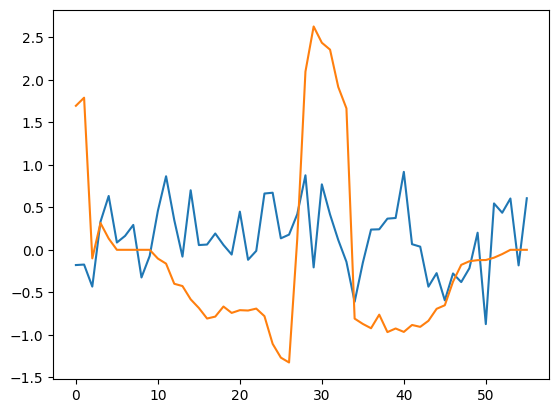

In [74]:
X_hat = ensemble.autoencoder(X_train.cuda())
plt.plot(X_hat.cpu().detach().numpy()[0,:])
plt.plot(X_train[0,:])

In [75]:
auto

autoNN(
  (encoder): ModuleList(
    (0): Linear(in_features=56, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=3, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=3, out_features=28, bias=True)
    (1): ReLU()
    (2): Linear(in_features=28, out_features=56, bias=True)
  )
)

In [76]:
# lets make a training loop from stratch
from torch import nn   
import torch.nn.functional as F
epochs = 1001
batch_size = 128
learning_rate = 0.0001
optimizer = torch.optim.Adam(ensemble.parameters(), lr=learning_rate)
losses = []
start = time.time()
for epoch in range(epochs):
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train[i:i+batch_size].cuda()
        y_batch = y_train[i:i+batch_size].cuda()
        y_hat = ensemble(X_batch)
        loss = F.mse_loss(y_hat, y_batch)
        loss = loss + F.mse_loss(X_batch, ensemble.autoencoder(X_batch))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    if epoch % 10 == 0:
        end = time.time()
        print(f'epoch: {epoch} loss: {loss.item()} time: {end-start}')
        start = time.time()

epoch: 0 loss: 1.1553593873977661 time: 0.6427016258239746
epoch: 10 loss: 0.9429320096969604 time: 5.463641881942749
epoch: 20 loss: 0.8902621865272522 time: 5.002463340759277
epoch: 30 loss: 0.8495017290115356 time: 4.668476581573486
epoch: 40 loss: 0.8019582629203796 time: 4.714692115783691
epoch: 50 loss: 0.7556188106536865 time: 4.709740400314331
epoch: 60 loss: 0.7125640511512756 time: 4.81894588470459
epoch: 70 loss: 0.667679488658905 time: 4.672482967376709
epoch: 80 loss: 0.6288818120956421 time: 4.667527198791504
epoch: 90 loss: 0.5965597629547119 time: 4.554179906845093
epoch: 100 loss: 0.5689740180969238 time: 4.602143049240112
epoch: 110 loss: 0.54728102684021 time: 4.925105571746826
epoch: 120 loss: 0.5312874913215637 time: 4.536420822143555
epoch: 130 loss: 0.5185561776161194 time: 4.838508129119873
epoch: 140 loss: 0.5068295001983643 time: 4.682746648788452
epoch: 150 loss: 0.4960095286369324 time: 4.53169584274292
epoch: 160 loss: 0.4861963391304016 time: 4.65243792533

r2: 0.9277076227009753
mse: 0.22276782989501953
rmse: 0.47198287034067193
mae: 0.31430038809776306


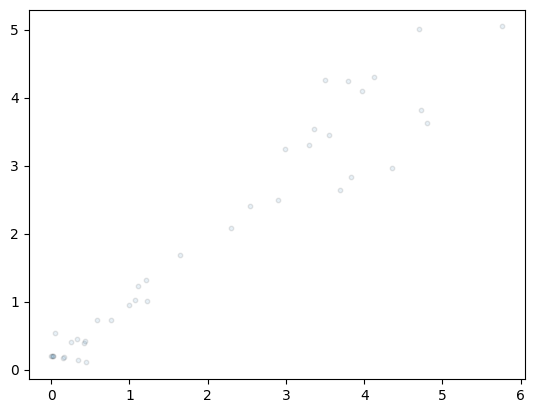

In [77]:
# plot the parity line 
# check if the test is on torch/gpu
#X_test = torch.from_numpy(X_test).float()
#y_test = torch.from_numpy(y_test).float()
X_test = X_test.cuda()
y_test = y_test.cuda()
#y_test = torch.from_numpy(y_test).float().cuda()
plt.scatter(y_test.cpu().detach().numpy(), ensemble(X_test.cuda()).cpu().detach().numpy(), alpha=0.1, s=10, edgecolors='k')
print(f'r2: {kmk.r2_score(y_test.cpu().detach().numpy(), ensemble(X_test.cuda()).cpu().detach().numpy())}')
print(f'mse: {kmk.mean_squared_error(y_test.cpu().detach().numpy(), ensemble(X_test.cuda()).cpu().detach().numpy())}')
print(f'rmse: {kmk.mean_squared_error(y_test.cpu().detach().numpy(), ensemble(X_test.cuda()).cpu().detach().numpy())**0.5}')
print(f'mae: {kmk.mean_absolute_error(y_test.cpu().detach().numpy(), ensemble(X_test.cuda()).cpu().detach().numpy())}')

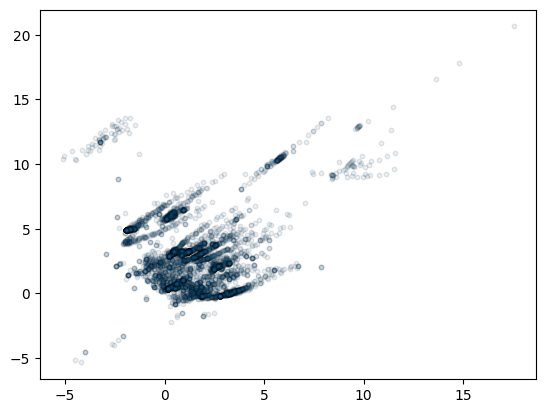

In [63]:
X_encoded = ensemble.autoencoder.encode(X_train.cuda())
plt.scatter(X_encoded.cpu().detach().numpy()[:,0], X_encoded.cpu().detach().numpy()[:,1], alpha=0.1, s=10, edgecolors='k')

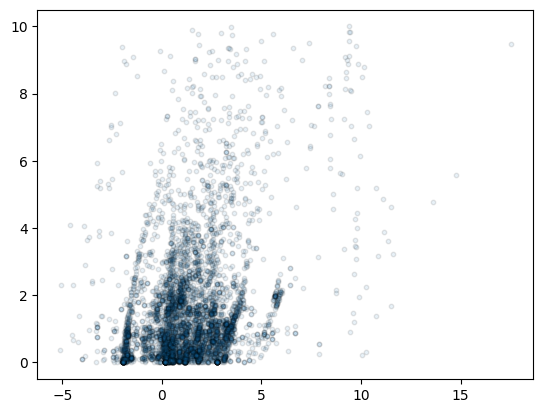

In [64]:
# plot the X_encoded vs y_train
plt.scatter(X_encoded.cpu().detach().numpy()[:,0], y_train, alpha=0.1, s=10, edgecolors='k')

In [65]:
import plotly.express as px
fig = px.scatter(x=X_encoded.cpu().detach().numpy()[:,0].reshape(-1), y=y_train.reshape(-1))
fig.show()

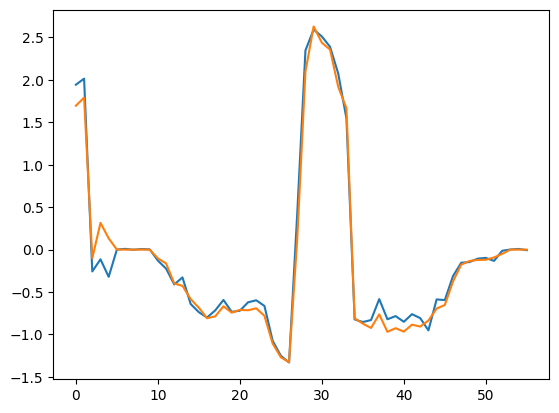

In [66]:
X_hat = ensemble.autoencoder.decode(X_encoded)
plt.plot(X_hat.cpu().detach().numpy()[0,:])
plt.plot(X_train[0,:])

In [67]:
# lets do pca on X_encoded
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded.cpu().detach().numpy())
px.scatter(x=X_pca[:,0], y=X_pca[:,1])

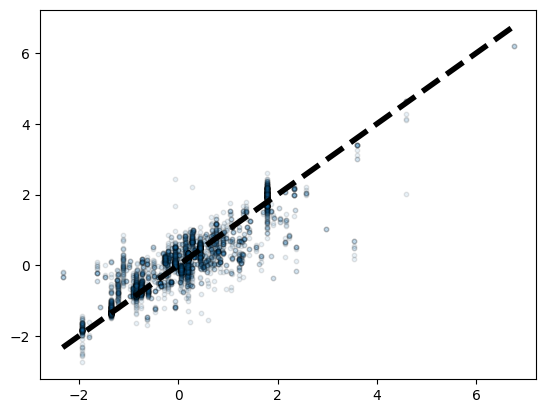

In [68]:
# scatter plot the X vs X_hat. Flatten before plotting. plot only first 2 columns
plt.scatter(X_train[:,1], X_hat.cpu().detach().numpy()[:,1], alpha=0.1, s=10, edgecolors='k')
# parity line extends through the whole plot
plt.plot([X_train[:,1].min(), X_train[:,1].max()], [X_train[:,1].min(), X_train[:,1].max()], 'k--', lw=4)